# TransientTest_SN2010mc-like supernova# 

**2016-04-12** - Updated from 2015-era OpSim runs and MAF version. Only minor adjustments: path to OpSim runs changed; names of the opsim runs changed; variable names changed to be a bit more general: "\*1092\*" --> "\*PSlike\*" and "\*1189\*" --> "\*Baseline\*". [The Notebook's "find and replace" feature was used to make the replacements quickly.]

**2016-01-09** - push towards a figure of merit. In this case, fraction of galactic supernovae that might be discovered. Use existing diagnostic metrics for this case.

We use a "typical" Type 1a lightcurve (e.g. Firth et al. 2015 MNRAS 446, 3895): rising $\alpha \approx 2.4$, time to peak $18.98 \pm 0.54 \approx 19.0$ days. Decay time $\approx 100$ days.

**2016-04-10 WIC update:** The notebooks in the github repository "lsstScratchWIC" can look for previously-run metrics in a subdirectory of the repository: [topDir]/data/metricOutputs . There is now a (commented) step below to run this metric so that the outputs go to that location (and will thus be easily read by e.g. FigureOfMerit_4p3_Galactic_Supernova.ipynb).

In [1]:
%matplotlib inline

In [2]:
import time

In [3]:
# If the next cell fails, check that you ran the setup scripts for sims-maf before opening this notebook!

In [4]:
# Follow the steps of PeterY's notebook
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

In [5]:
# LSST stuff
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [6]:
import os

In [7]:
from lsst.sims.maf.metrics import calibrationMetrics

In [8]:
import lsst.sims.maf.metrics as metrics

In [9]:
metrics.__file__


'/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/metrics/__init__.pyc'

In [10]:
calibrationMetrics.__all__

['ParallaxMetric',
 'ProperMotionMetric',
 'RadiusObsMetric',
 'ParallaxCoverageMetric',
 'ParallaxHADegenMetric']

### Setting paths appropriately ###

In [11]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository. 

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#os.chdir('%s/data/metricOutputs' % (topDir))

In [12]:
# Default is to assume the databases are symlinked into the current directory.
# opsimDir = os.getcwd()

# uncomment the following to set the directory on your system where the opsim runs are stored:
opsimDir='/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411'

In [13]:
# Note that notebooks can be called from a directory other than the one
# in which they are stored. I called this notebook as follows:

# jupyter notebook /Users/clarkson/Progs/Projects/lsstScratchWIC/notebooks/TransientTest_CompareWithPanSTARRS-LikeSN2010mc.ipynb

# However the ! pwd and os.getcwd() then return different things! Need to be careful...

! pwd

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411


In [14]:
# Output directory for intermediate products
outDir=os.getcwd()


In [15]:
print outDir

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411


### Set parameters for the transient ###

In [16]:
# Take a look at a synthetic lightcurve set. A SN in the MW could get very bright indeed...

# The way peterY's transient seems to work, the lightcurve is constructed outward
# from the peak. So make the peaks very bright...
peaks = {'uPeak':11, 'gPeak':9, 'rPeak':8, 'iPeak':7, 'zPeak':6,'yPeak':6}
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']



In [17]:
# Timing parameters of the outbursts
riseSlope = -2.4
# riseSlope = -0.5  # Changing riseSlope changes the faintest mag this reaches b4 peak.
#declineSlope = 0.05  # Make this steeper for prompt emission (and to fit more tests in)
declineSlope = 0.05  # following Ofek et al. 2013
transDuration = 80.
peakTime = 20.

### Taking a look at the transient lightcurve ###


In [18]:
transMetric = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      **peaks)

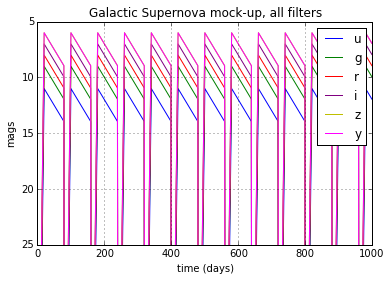

In [19]:
# try plotting:
times = np.arange(1000.)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([25,5])
#plt.xlim(0, transDuration)
plt.legend()
plt.title('Galactic Supernova mock-up, all filters')
plt.grid()

## Set up metric list we want, r-only to assess cadence only. ##

In [20]:
slicer = slicers.HealpixSlicer(nside=64)
summaryMetrics = [metrics.MedianMetric()]

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [21]:
nPhaseCheck=20
nPrePeak=3
metricList = []
metricAlert = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      metricName='Alert, sawtooth', \
                                     nPhaseCheck=nPhaseCheck, **peaks)

metricRise = metrics.TransientMetric(riseSlope=riseSlope, declineSlope=declineSlope, \
                                      transDuration=transDuration, peakTime=peakTime, \
                                      metricName='%i detections on rise' % (nPrePeak), \
                                    nPrePeak=nPrePeak, \
                                    nPhaseCheck=nPhaseCheck, **peaks)

metricList = [metricAlert, metricRise]
#metricList=[metricRise]

## Setup for PanSTARRS-like cadence ##

In [22]:
runNamePSlike = 'minion_1020'
#sqlconstraint = 'filter = "r"'
sqlconstraint = ''
bDictPSlike={}
for i,metric in enumerate(metricList):
    bDictPSlike[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runNamePSlike, summaryMetrics=summaryMetrics)

In [23]:
opsdbPSlike = db.OpsimDatabase(opsimDir + '/' + runNamePSlike + '_sqlite.db')
outDirPSlike = '%s/TransientsLike2010mc_PSlike' % (outDir)
resultsDbPSlike = db.ResultsDb(outDir=outDirPSlike)

## Setup for Baseline cadence##

In [24]:
runNameBaseline = 'minion_1016'
#sqlconstraint = 'filter = "r"'
bDictBaseline={}
for i,metric in enumerate(metricList):
    bDictBaseline[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runNameBaseline, summaryMetrics=summaryMetrics)

In [25]:
opsdbBaseline = db.OpsimDatabase(opsimDir + '/' + runNameBaseline + '_sqlite.db')
outDirBaseline = '%s/TransientsLike2010mc_Baseline' % (outDir)
resultsDbBaseline = db.ResultsDb(outDir=outDirBaseline)

## Run both!! ##

Querying database with no constraint.
Found 2429023 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 0.779898  dipole: lon: 109.402, lat: -68.8244, amp: 0.105579


/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 200 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.25495  dipole: lon: 33.2514, lat: -18.1403, amp: 0.00547024
Plotting complete.
Time spent on PSlike: 3.965e+02 seconds


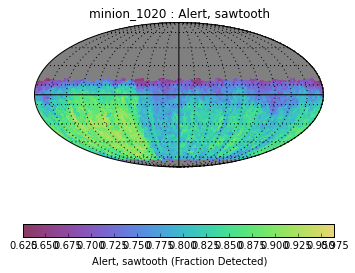

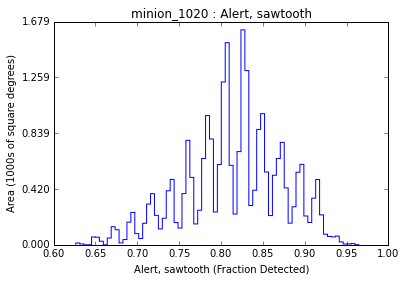

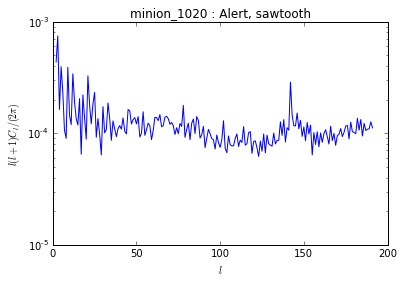

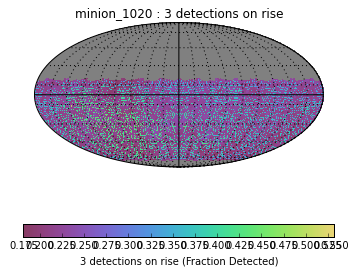

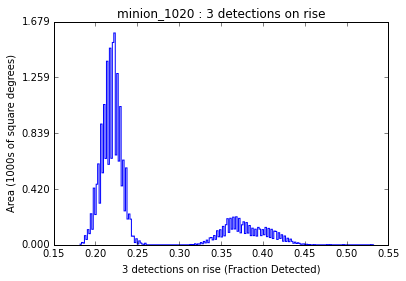

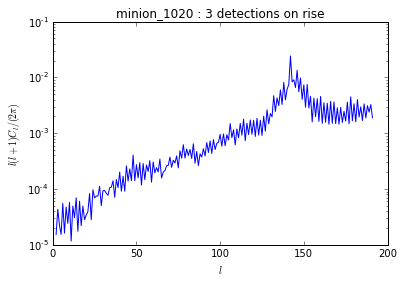

In [26]:
tStart = time.time()
bgroupPSlike = metricBundles.MetricBundleGroup(bDictPSlike, opsdbPSlike, outDir=outDirPSlike, \
                                             resultsDb=resultsDbPSlike)
bgroupPSlike.runAll()
bgroupPSlike.plotAll(closefigs=False)
tPostPSlike = time.time()
print "Time spent on PSlike: %.3e seconds" % (tPostPSlike - tStart)

Querying database with no constraint.
Found 2447931 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 0.589341  dipole: lon: 88.5799, lat: -60.5989, amp: 0.119827
monopole: 0.212481  dipole: lon: 91.396, lat: -67.1975, amp: 0.0531765
Plotting complete.
Time spent on Baseline: 1.133e+04 seconds


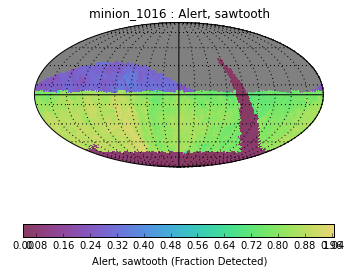

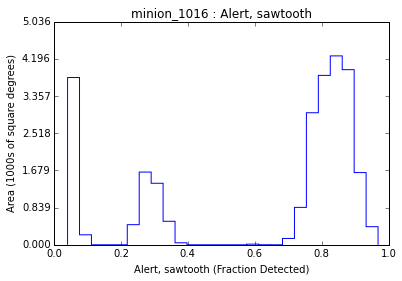

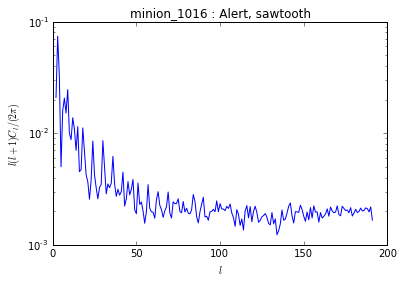

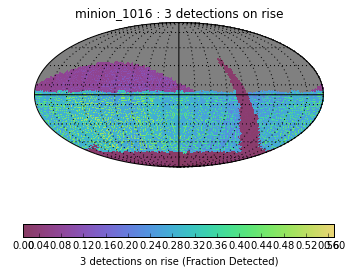

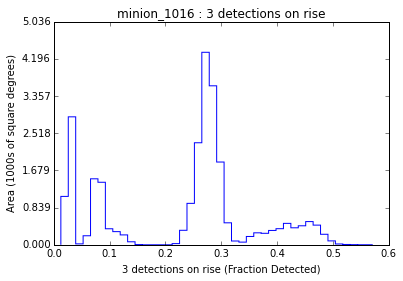

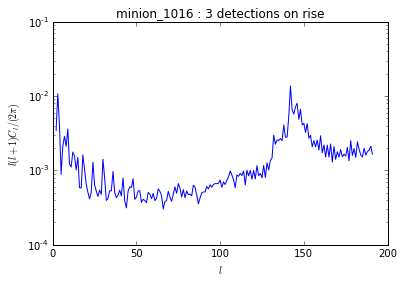

In [27]:
tPostPSlike = time.time()
bgroupBaseline = metricBundles.MetricBundleGroup(bDictBaseline, opsdbBaseline, outDir=outDirBaseline, \
                                             resultsDb=resultsDbBaseline)
bgroupBaseline.runAll()
tPostBaseline = time.time()
bgroupBaseline.plotAll(closefigs=False)
print "Time spent on Baseline: %.3e seconds" % (tPostBaseline - tPostPSlike)

